In [1]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

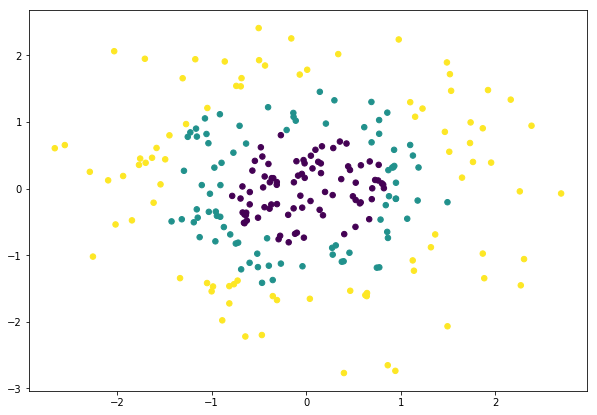

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = make_gaussian_quantiles(n_features=2, n_classes=3, n_samples=250)
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], s=30, c=y)

In [3]:
# Train the logistic rgeression classifier
logreg_clf = LogisticRegressionCV()
logreg_clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
def plot_decision_boundary(predict, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.007
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral_r)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
del X, y

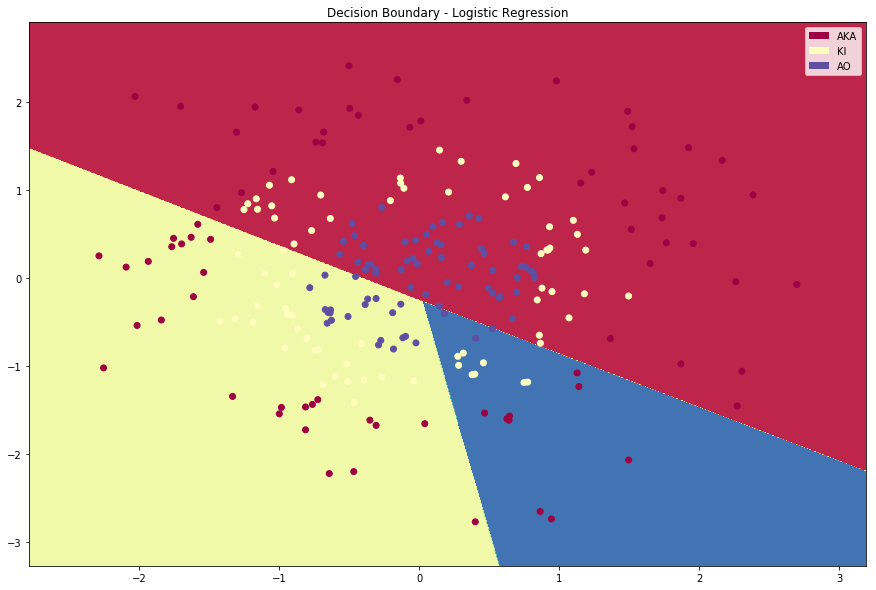

In [6]:
# Plot the decision boundary
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: logreg_clf.predict(x), X_train, y_train)
plt.title("Decision Boundary - Logistic Regression")

classes = ['AKA','KI', 'AO']
class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('Spectral')(127), plt.cm.get_cmap('Spectral')(255)]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
plt.legend(recs, classes, loc=1)

In [7]:
def my_tanh(array, backward=False):
    if backward:
        return (1 - np.power(array, 2))
    return np.tanh(array)

In [8]:
def my_sigmoid(array, backward=False):
    if backward:
        s = my_sigmoid(array)
        return s*(1 - s)
    return 1 / (1 + np.exp(-array))

In [9]:
def my_relu(array, hidden_values=None, backward=False):
    if backward and hidden_values is not None:
        array[hidden_values <= 0] = 0
        return array
    return np.maximum(0, array)

In [10]:
def my_softmax(array):
    ex = np.exp(array)
    return ex / np.sum(ex, axis=1, keepdims=True)

In [11]:
def forward_pass(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = my_tanh(z1)
    z2 = a1.dot(W2) + b2
    return my_softmax(z2), a1

In [12]:
def calc_loss(model, X, y, reg):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    probs, _ = forward_pass(model, X)
    correct_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(correct_logprobs)
    reg_loss = reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss = data_loss + reg_loss
    return loss / len(X)

In [13]:
def predict(model, X):
    probs, _ = forward_pass(model, X)
    return np.argmax(probs, axis=1)

In [14]:
def show_legend():
    classes = ['AKA','P_AKA', 'KI', 'P_KI', 'AO', 'P_AO']
    sp = plt.cm.get_cmap('Spectral')
    d2 = plt.cm.get_cmap('binary_r')
    class_colours = [sp(0), d2(0), sp(127), d2(127), sp(255), d2(255)]
    recs = []
    for i in range(len(class_colours)):
        recs.append(mpatches.FancyArrow(0, 1, 1, 1,1,fc=class_colours[i]))
    return plt.legend(recs, classes, loc=1)

In [15]:
input_size = 2 # input layer dimensionality -> position in the plane
output_size = 3 # output layer dimensionality -> 3 gaussian quantiles

def make_model(X, y, epochs, hidden_size, decay=None, batch_size=None, print_loss=None, lr=0.02, reg=0.01):

    def get_mini_batch(X, y, n_train, batch_size):
        mask = np.random.choice(a=n_train, size=batch_size, replace=False)
        return X[mask], y[mask]
    
    def one_hot(k):
        vector = np.zeros(3, dtype=int)
        vector[k] = 1
        return vector

    y = np.asarray([one_hot(i) for i in y])
    
    if batch_size is not None:
        N = batch_size
    else:
        N = len(X) # training set size 
        
    model = {}
    # ReLU weights
    model['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2/N)
    model['W2'] = np.random.randn(hidden_size, output_size) * np.sqrt(2/N)
    
    model['b1'] = np.zeros((1, hidden_size))
    model['b2'] = np.zeros((1, output_size))
    

    model['W1'] = 1e-4 * np.random.randn(input_size, hidden_size)
    model['W2'] = 1e-4 * np.random.randn(hidden_size, output_size)
    
    for i in range(epochs):
        if batch_size is not None:
            X, y = get_mini_batch(X, y, N, batch_size)
    
        # Forward
        probs, a1 = forward_pass(model, X)

        # Backward
        delta3 = probs - y
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(model['W2'].T) * my_tanh(a1, backward=True)
        #delta2 = my_relu(delta2, a1, backward=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (weights only)
        dW2 += reg * model['W2']
        dW1 += reg * model['W1']

        # LR decay
        if decay is not None:
            ratio, iterations = decay
            if i % iterations == 0:
                if 0 < ratio < 1:
                    lr -= lr * ratio
        
        # Gradient descent parameter update
        model['W1'] += -lr * dW1
        model['b1'] += -lr * db1
        model['W2'] += -lr * dW2
        model['b2'] += -lr * db2

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss is not None and i % print_loss == 0:
          print("Loss after iteration %i: %f" %(i, calc_loss(model, X_train, y_train, reg=reg)))
    return model

In [16]:
model = make_model(X_train, y_train, batch_size=100, lr=0.001, print_loss=5000, epochs=50001, hidden_size=3)

Loss after iteration 0: 1.098619
Loss after iteration 5000: 0.410528
Loss after iteration 10000: 0.307804
Loss after iteration 15000: 0.283734
Loss after iteration 20000: 0.264045
Loss after iteration 25000: 0.250514
Loss after iteration 30000: 0.240901
Loss after iteration 35000: 0.233753
Loss after iteration 40000: 0.228231
Loss after iteration 45000: 0.223841
Loss after iteration 50000: 0.220274


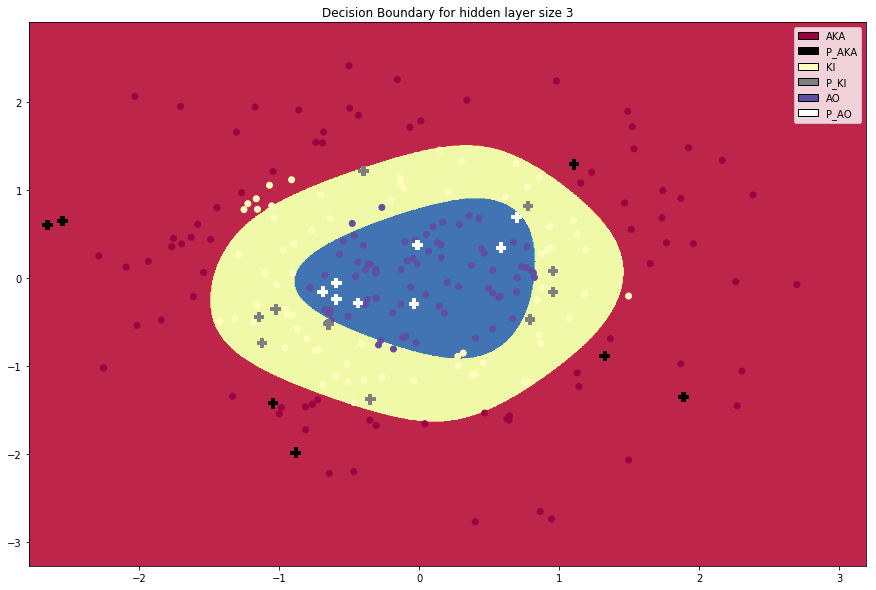

In [17]:
predictions = predict(model, X_test)
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)
plt.scatter(X_test[:,0], X_test[:,1], s=90, c=predictions, cmap=plt.cm.binary, marker='P')
plt.title("Decision Boundary for hidden layer size 3")
show_legend()

Loss after iteration 0: 1.098578
Loss after iteration 50000: 0.760282
Loss after iteration 100000: 0.759254
Loss after iteration 150000: 0.759042
Loss after iteration 200000: 0.758986
Loss after iteration 250000: 0.758970
Loss after iteration 300000: 0.758965
Loss after iteration 350000: 0.758964
Loss after iteration 400000: 0.758963
Loss after iteration 450000: 0.758963
Loss after iteration 500000: 0.758963
Loss after iteration 550000: 0.758963
Loss after iteration 600000: 0.758963
Loss after iteration 650000: 0.758963
Loss after iteration 700000: 0.758963
Loss after iteration 750000: 0.758963
Loss after iteration 0: 1.098578
Loss after iteration 50000: 0.178663
Loss after iteration 100000: 0.182691
Loss after iteration 150000: 0.185348
Loss after iteration 200000: 0.185873
Loss after iteration 250000: 0.190974
Loss after iteration 300000: 0.188967
Loss after iteration 350000: 0.196495
Loss after iteration 400000: 0.198665
Loss after iteration 450000: 0.191507
Loss after iteration 500

ValueError: num must be 1 <= num <= 10, not 11

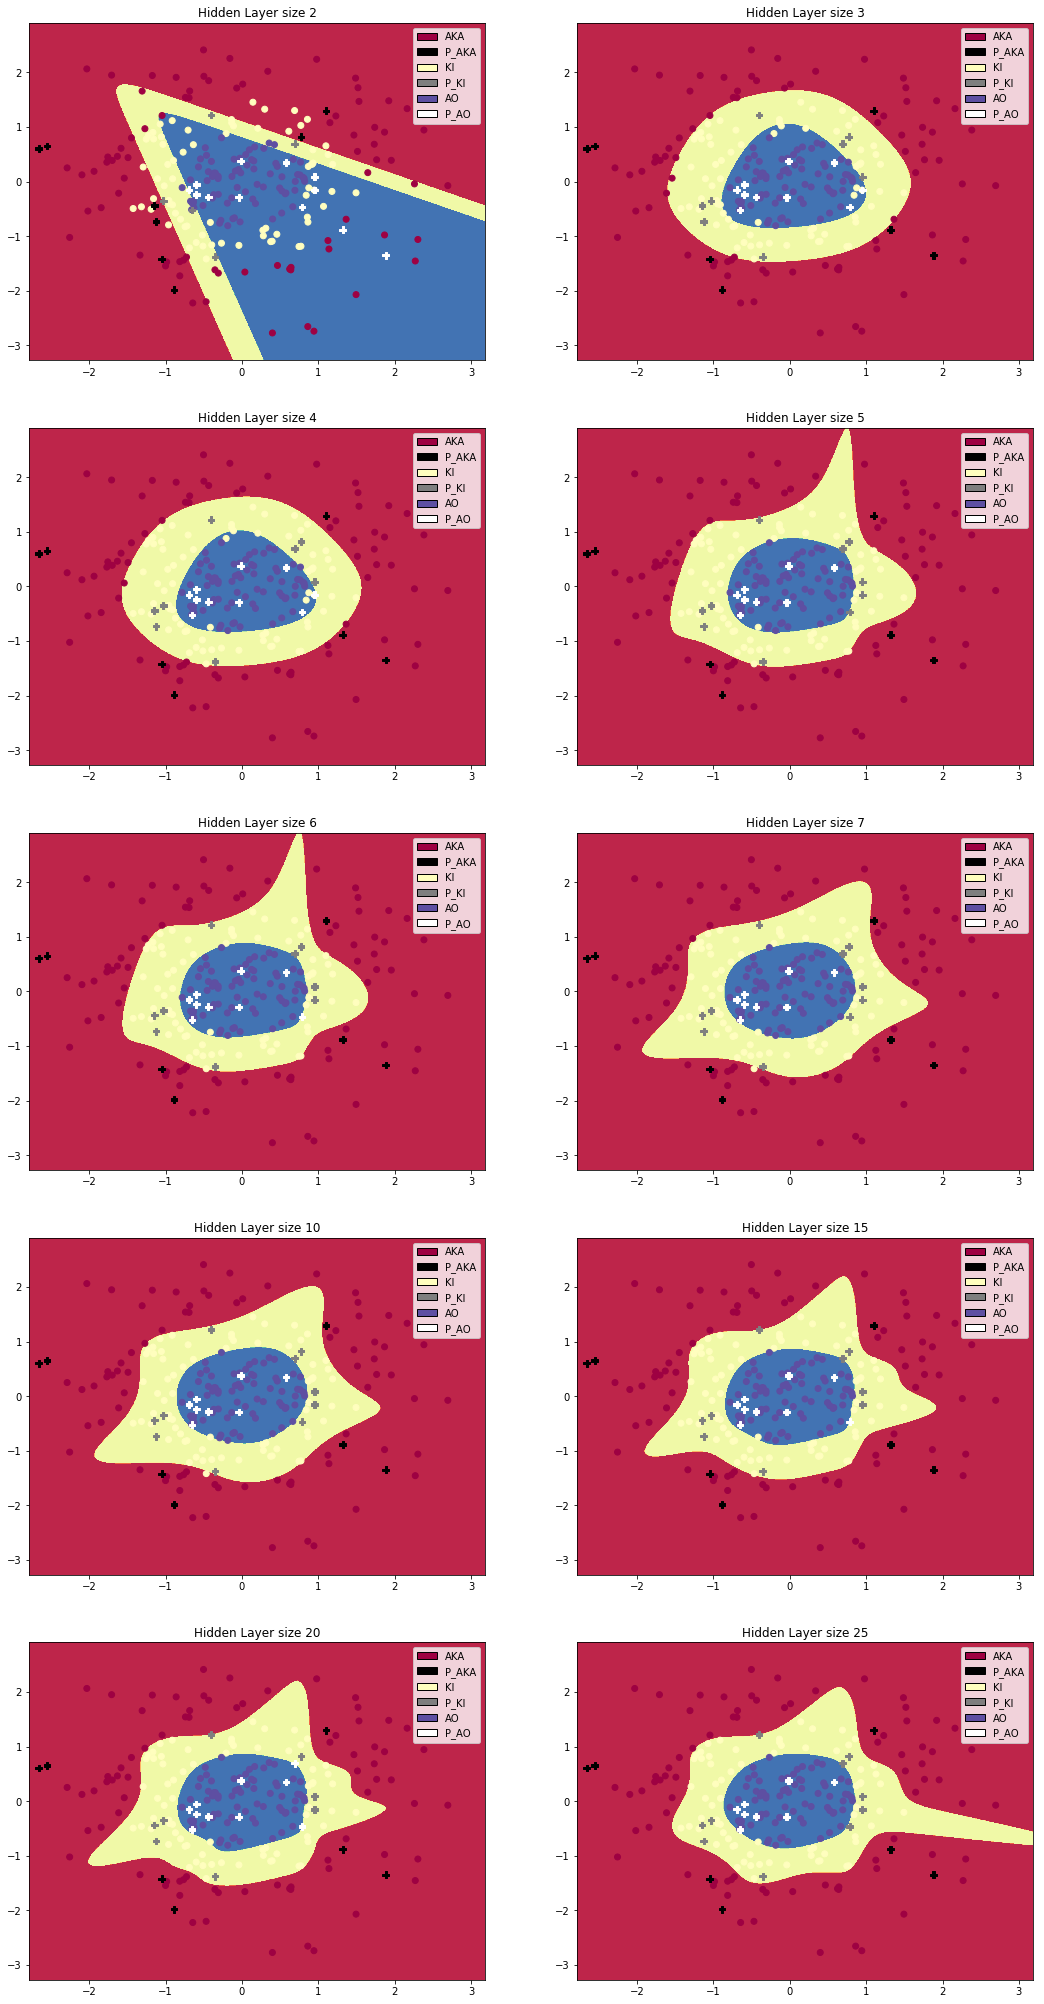

In [19]:
plt.figure(figsize=(18, 36))
hidden_sizes = [2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 50, 100]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 750001, hidden_sizes[i], lr=0.001, print_loss=50000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)
    plt.scatter(X_test[:,0], X_test[:,1], s=45, c=predictions, cmap=plt.cm.binary, marker='P')
    show_legend()
plt.show()